## Integral Method (Green Function)
$$
\begin{aligned}
\Delta u + k^2 u = f\\
\lim_{r\rightarrow \infty} \frac{1}{\sqrt{r}} (\frac{\partial u}{\partial r}-iku) = 0
\end{aligned}
$$
For $f$ with compact support $\Omega$, Compute $G(x,y)$:
$$
\begin{aligned}
\Delta G(x,x_s) + k^2 G(x,x_s) = \delta(x - x_s) \quad \text{in} \quad \mathbb{R}^2\\
G(x,x_s) = -\frac{i}{4} H_0^{(1)}(k|x-x_s|)
\end{aligned}
$$
Then we have
$$
\begin{aligned}
\Delta u(x) + k^2u(x) =f(x) = \int_\Omega \delta(x-x_s) f(x_s) dx_s \\
=\int_\Omega (\Delta G(x,x_s) + k^2G(x,x_s)) f(x_s) dx_s\\
\Rightarrow u(x) = \int_\Omega G(x,x_s) f(x_s) dx_s
\end{aligned}
$$  

## Neumann Series
We focus on the following problem:
$$
\begin{aligned}
\Delta u_t + k^2(1+q) u_t &= -k^2qf\\
\lim_{r\rightarrow \infty} \frac{1}{\sqrt{r}} (\frac{\partial u_t}{\partial r}-iku_t) &= 0  \qquad \qquad(*)
\end{aligned}
$$
which can be decomposed as
$$
\begin{aligned}
\Delta u_0 + k^2 u_0 &= -k^2qf  \\
\Delta u_1 + k^2 u_1 &= -k^2qu_0 \\
\Delta u_2 + k^2 u_2 &= -k^2qu_1 \\
\ldots \\
\Delta u_{n+1} + k^2 u_{n+1} &= -k^2qu_n \\
\ldots \\
u_t &= \sum_{i=0}^{\infty} u_i
\end{aligned}
$$

In [1]:
from scipy.special import hankel1 as hk
from Solver import *
from q_method import *
def Integral_Kernel(N,k):
    l = np.linspace(0,1,N+1)
    X_ABS, Y_ABS = np.meshgrid(l, l, indexing='ij')
    HANKEL_BENCHMARK = -1j/4*hk(0,k*np.sqrt(X_ABS**2+Y_ABS**2))
    l1 = np.arange(N+1)
    X1, Y1, X2, Y2 = np.meshgrid(l1, l1, l1, l1, indexing='ij')
    G = HANKEL_BENCHMARK[np.abs(X1-X2),np.abs(Y1-Y2)]
    G[np.isnan(G)] = 0. + 1j*0.
    Matrix_Integral = 0.5*np.ones((N+1,N+1))
    Matrix_Integral[1:-1,1:-1] = 1.
    Matrix_Integral[0,0] = Matrix_Integral[-1,0] = Matrix_Integral[0,-1] = Matrix_Integral[-1,-1] = 0.25
    Matrix_Integral /= N * N
    return G, Matrix_Integral
def A(u):
    ans = u[:-2,1:-1] + u[2:,1:-1] + u[1:-1,2:] + u[1:-1,:-2] - 4*u[1:-1,1:-1]
    return ans
def B(u):
    ans = u[:-2,:-2] + u[2:,2:] + u[:-2,2:] + u[2:,:-2] - 4*u[1:-1,1:-1]
    return ans

In [2]:
N = 128
k = 20
G, Matrix_Integral = Integral_Kernel(N, k)

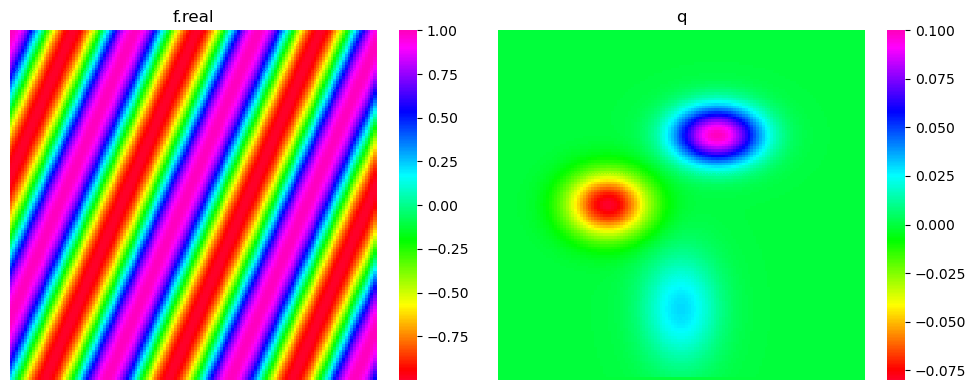

In [3]:
f = f_gen(N,k,16)[3]
q = 0.1*q_gen(N,'MG')
heatmap_for_test(f.real,q,label_list=['f.real','q'],loss=False)

In [4]:
%time u_0 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-k*k*q*f))
u_1 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q*k*k*u_0))
u_2 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q*k*k*u_1))
u_3 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q*k*k*u_2))
u_4 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q*k*k*u_3))
u_5 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q*k*k*u_4))
u_6 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q*k*k*u_5))
u_7 = np.einsum('ijkl,kl->ij', G, Matrix_Integral*(-q*k*k*u_6))
print(np.linalg.norm(u_7))
u_t = u_0 + u_1 + u_2 + u_3 + u_4 + u_5 + u_6 + u_7

CPU times: user 535 ms, sys: 0 ns, total: 535 ms
Wall time: 534 ms
7.979084513621159e-08


相对误差为2.28%


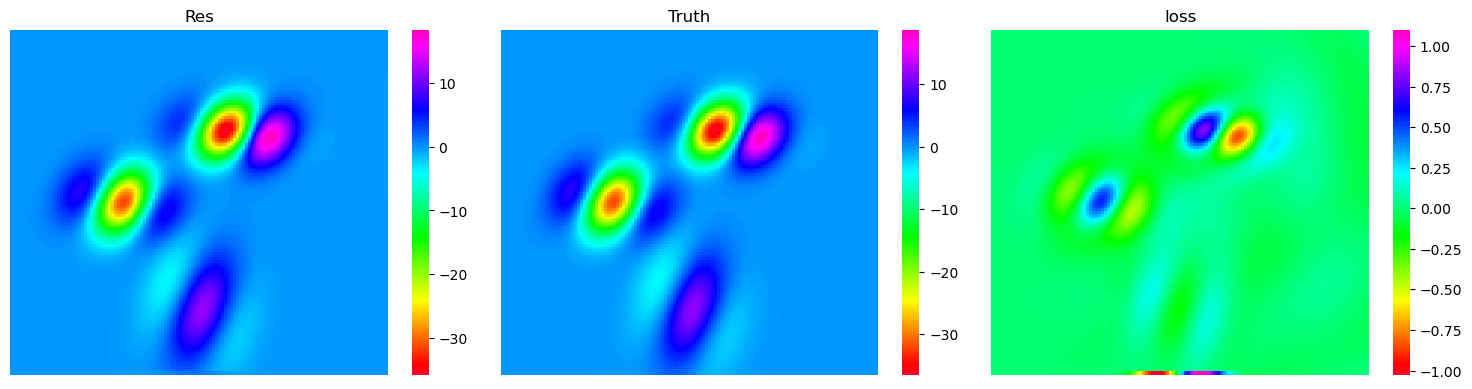

In [5]:
rhs = A(u_t)*N*N + k*k*(1+q[1:-1,1:-1])*u_t[1:-1,1:-1]
# rhs = (B(u_t)/6+A(u_t)*2/3)*N*N + k*k*(1+q[1:-1,1:-1])*u_t[1:-1,1:-1]
heatmap_for_test(rhs.real,-(k*k*q*f).real[1:-1,1:-1],label_list=['Res','Truth','loss'],loss=True)

## Absorbing Boundary Condition
($*$) is defined on $R^2$, we only focus on the solution restricted to $\Omega =[0,1]^2$.  
As a result, an absorbing boundary condition is introduced:
$$
\begin{aligned}
\Delta u^{(1)} + k^2(1+q) u^{(1)} &= -k^2qf \quad \text{in} \quad \Omega\\
\frac{\partial u^{(1)}}{\partial r} &= iku^{(1)}  \quad \text{on}\quad {\partial \Omega}\qquad \qquad(1)
\end{aligned}
$$
To make sure $u^{(1)}$ approximates $u_t$, the boundary to satisfies the robin boundary condition should be as outter as possible:
$$
\begin{aligned}
\Delta u^{(m)} + k^2(1+q^{(m)}) u^{(m)} &= -k^2q^{(m)}f^{(m)} \quad \text{in} \quad  \Omega_1 = [0,m]^2, m \in \mathbb{N}^{+}, m > 1\\
\frac{\partial u^{(m)}}{\partial r} &= iku^{(m)}  \quad \text{on}\quad {\partial \Omega_1}\qquad \qquad(2)
\end{aligned}
$$
Define $\Omega_2 = [\frac{m-1}{2},\frac{m+1}{2}]^2 \subset \Omega_1, q^{(m)}|_{\Omega_2} = q|_{\Omega},f^{(m)}|_{\Omega_2} = f|_{\Omega}$, then $u^{(m)}|_{\Omega_2}$ is a better approximation then $u|_{\Omega}$

CPU times: user 619 ms, sys: 34.5 ms, total: 654 ms
Wall time: 653 ms
CPU times: user 23.6 s, sys: 898 ms, total: 24.5 s
Wall time: 818 ms
CPU times: user 7.27 s, sys: 317 ms, total: 7.59 s
Wall time: 237 ms
相对误差为2.36%


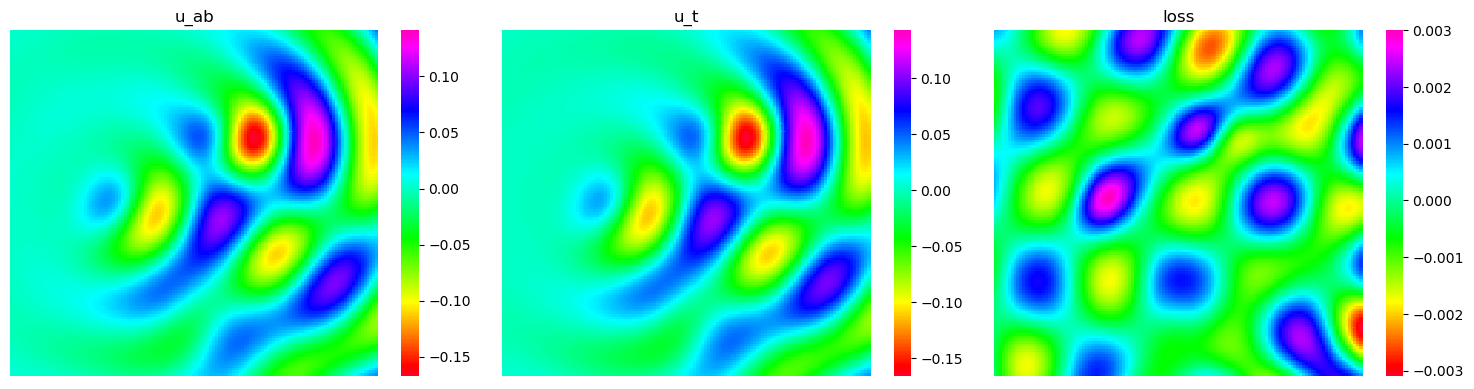

In [6]:
expand_times = 2
%time Matrix_analysis(N,expand_times=expand_times)
%time Matrix_factorize(N, k,q.reshape(-1,),expand_times=expand_times)
%time u_ab = Matrix_solve(-(k*k*q*f).reshape(-1,),expand_times=expand_times).reshape(N+1,N+1)
heatmap_for_test(u_ab.real,u_t.real,label_list=['u_ab','u_t','loss'],loss=True)